# Radar With Surface Obs
Plots radar and surface observations, using Pyart to read in the radar data, Matplotlib to plot it, and Metpy to read in and plot the station plots.

In [38]:
from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import pyart
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import get_wind_components, get_layer
from metpy.units import units
from metpy.calc import lcl, log_interp
import scipy.ndimage as ndimage

Direct RadarServer to the correct link to the Amazon S3 server with the radar data.

In [3]:
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')
#rs = RadarServer('http://thredds.ucar.edu/thredds/radarServer/nexrad/level2/IDD/')

Use RadarServer and Pyart to pull in a radar object for the scan we want.

In [4]:
query = rs.query()
dt = datetime(2017, 6, 12, 22, 0) # Our specified time
query.stations('KCYS').time(dt)
cat = rs.get_catalog(query)
for item in sorted(cat.datasets.items()):
    # Pull the actual Dataset object out
    # of our list of items and access over OPENDAP
    ds = item[1]
radar = pyart.io.nexrad_cdm.read_nexrad_cdm(ds.access_urls['OPENDAP'])
#Pull out only the lowest tilt
radar = radar.extract_sweeps([0])
#Pull the timestamp from the radar file
time_start = netCDF4.num2date(radar.time['data'][0], radar.time['units'])

Using Pyart, pull in location info and base reflectivity

In [5]:
rlons = radar.gate_longitude['data']
rlats = radar.gate_latitude['data']
cenlat = radar.latitude['data'][0]
cenlon = radar.longitude['data'][0]
#Pull reflectivity from the radar object
refl = radar.fields['reflectivity']['data']
#Mask noisy stuff below 20 dbZ
refl = ma.masked_less(refl, 20.)

Create a figure to plot our radar and stations on

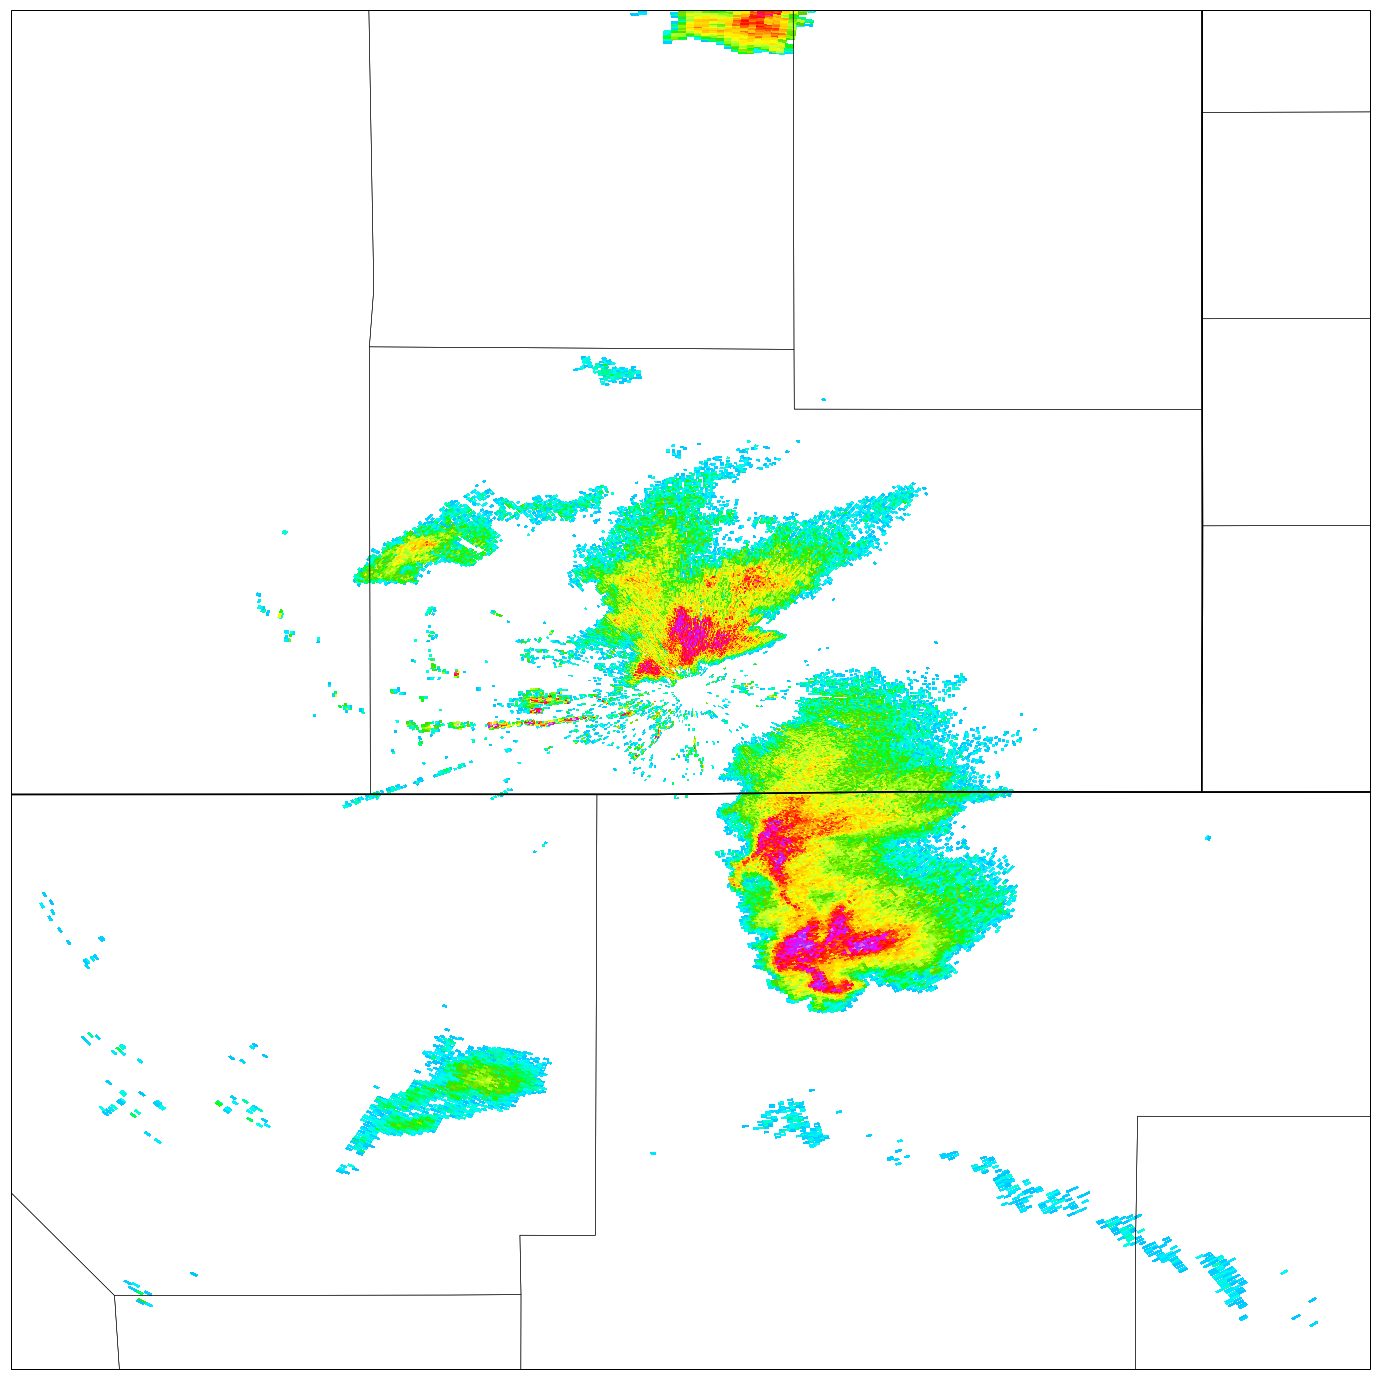

In [6]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
# Set up our array of latitude and longitude values and transform to 
# the desired projection.
tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),rlons,rlats)
tlons = tlatlons[:,:,0]
tlats = tlatlons[:,:,1]
# Limit the extent of the map area to around the radar, must convert to proper coords.
LL = (cenlon-1.,cenlat-1.,ccrs.PlateCarree())
UR = (cenlon+1.,cenlat+1.0,ccrs.PlateCarree())
# Get data to plot state and province boundaries
#states_provinces = cfeature.NaturalEarthFeature(
#        category='cultural',
#        name='admin_1_states_provinces_lakes',
#        scale='50m',
#        facecolor='none')
#Read in state and county boundary shapefiles
fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'
counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
#Create the figure
%matplotlib inline
fig=plt.figure(1,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)

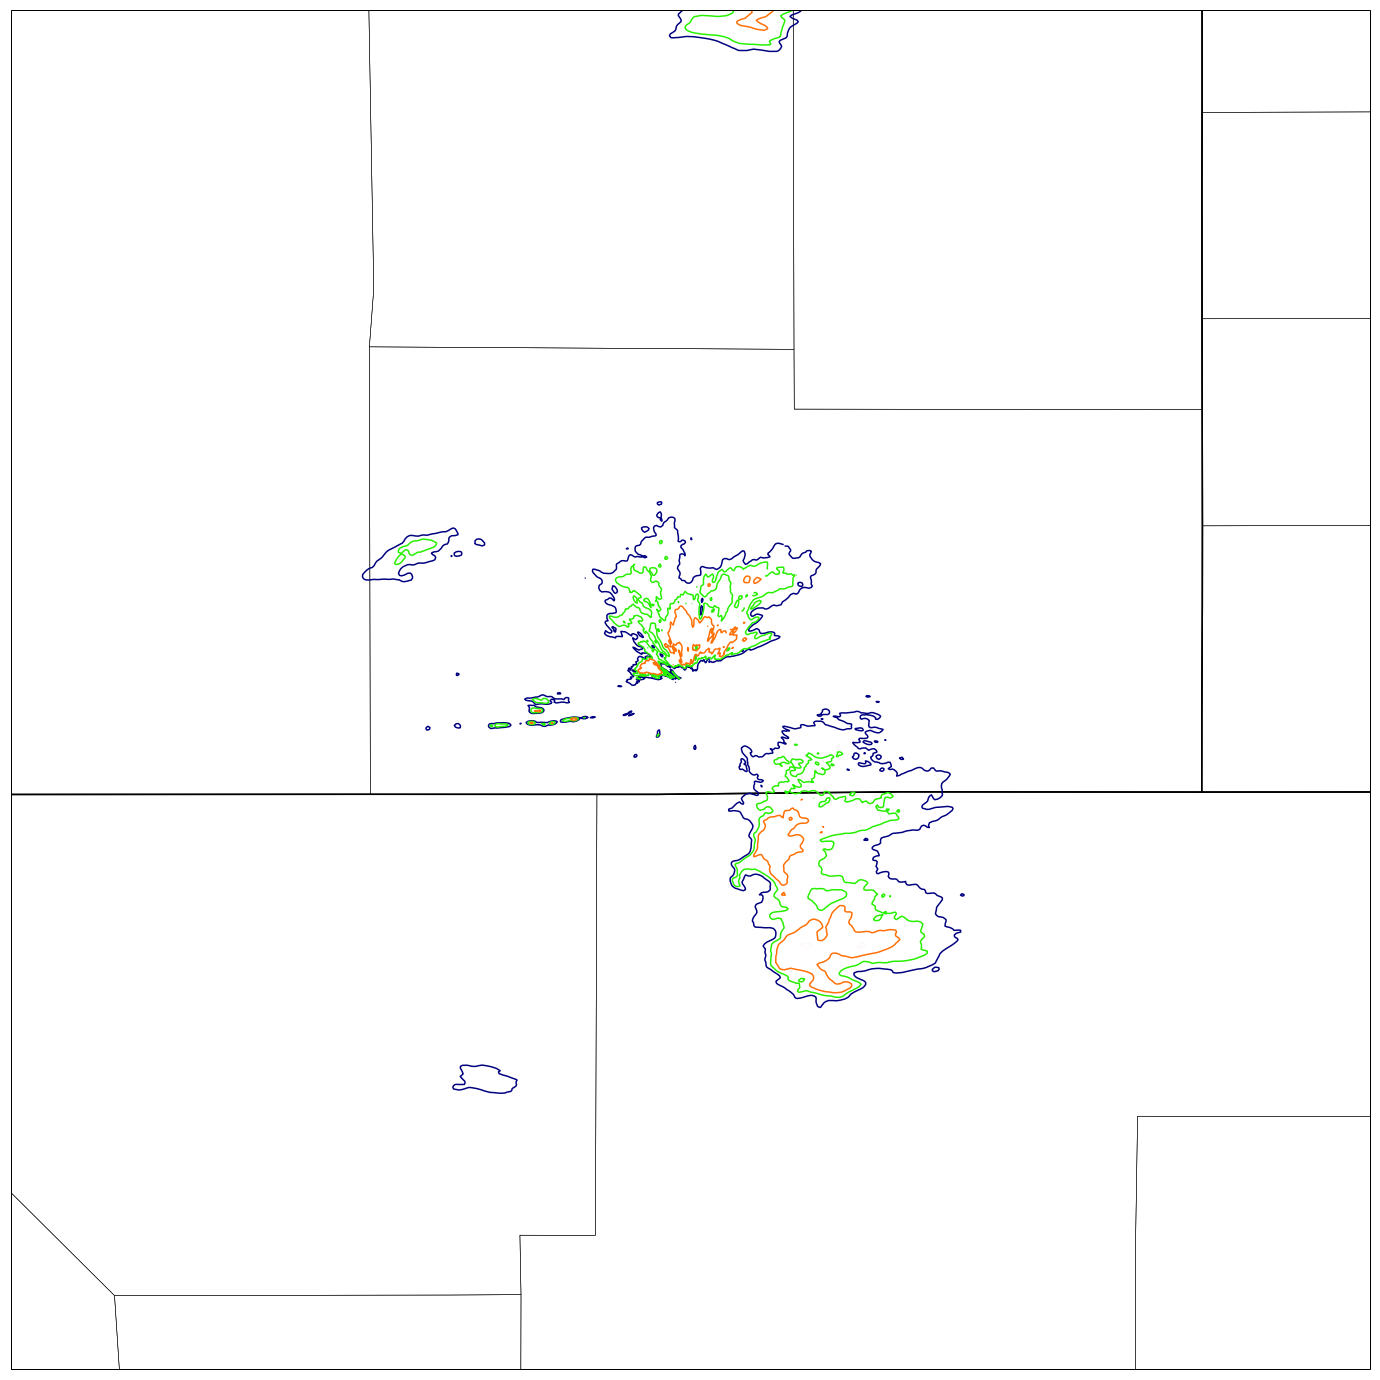

In [43]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)
# Set up our array of latitude and longitude values and transform to 
# the desired projection.
tlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),rlons,rlats)
tlons = tlatlons[:,:,0]
tlats = tlatlons[:,:,1]
# Limit the extent of the map area to around the radar, must convert to proper coords.
LL = (cenlon-1.,cenlat-1.,ccrs.PlateCarree())
UR = (cenlon+1.,cenlat+1.0,ccrs.PlateCarree())
# Get data to plot state and province boundaries
#states_provinces = cfeature.NaturalEarthFeature(
#        category='cultural',
#        name='admin_1_states_provinces_lakes',
#        scale='50m',
#        facecolor='none')
#Read in state and county boundary shapefiles
fname = 'cb_2016_us_county_20m/cb_2016_us_county_20m.shp'
fname2 = 'cb_2016_us_state_20m/cb_2016_us_state_20m.shp'
counties = ShapelyFeature(Reader(fname).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
states = ShapelyFeature(Reader(fname2).geometries(),ccrs.PlateCarree(), facecolor = 'none', edgecolor = 'black')
#Create the figure
%matplotlib inline
fig=plt.figure(1,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
#Plot our radar data
rlevs = np.arange(30,70,10)
#refp = ax.contour(rlons, rlats, refl, cmap=plt.cm.gist_ncar)
refl_sm = ndimage.gaussian_filter(refl, sigma=1, order=0)
refp = ax.contour(rlons, rlats, refl_sm, rlevs, cmap=plt.cm.gist_ncar)

Now let's add some station plots to our map!

In [8]:
#Point to the URL for the station data on the Unidata thredds server
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# Parse the xml
catalog = TDSCatalog(metar_cat_url)
metar_dataset = catalog.datasets['Feature Collection']
ncss_url = metar_dataset.access_urls['NetcdfSubset']
# Import ncss client
ncss = NCSS(ncss_url)
#Set date/time to be the time from our radar scan
start_time = datetime(time_start.year, time_start.month, time_start.day, time_start.hour, time_start.minute)
#Create a query to access the data
query = ncss.query()
query.lonlat_box(north=cenlat+1., south=cenlat-1., east=cenlon+1., west=cenlon-1)
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.accept('csv')
#Get the data
data = ncss.get_data(query)

Pull the station data out of our data object and add/convert units where needed.

In [9]:
# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:] * units('degC')
dewp = data['dew_point_temperature'][:] * units('degC')
tair = tair.to('degF').magnitude
dewp = dewp.to('degF').magnitude
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = get_wind_components(data['wind_speed'], data['wind_from_direction'] * units.degree)

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 10
cloud_cover = cloud_cover.astype(np.int)

Now we can plot everything together

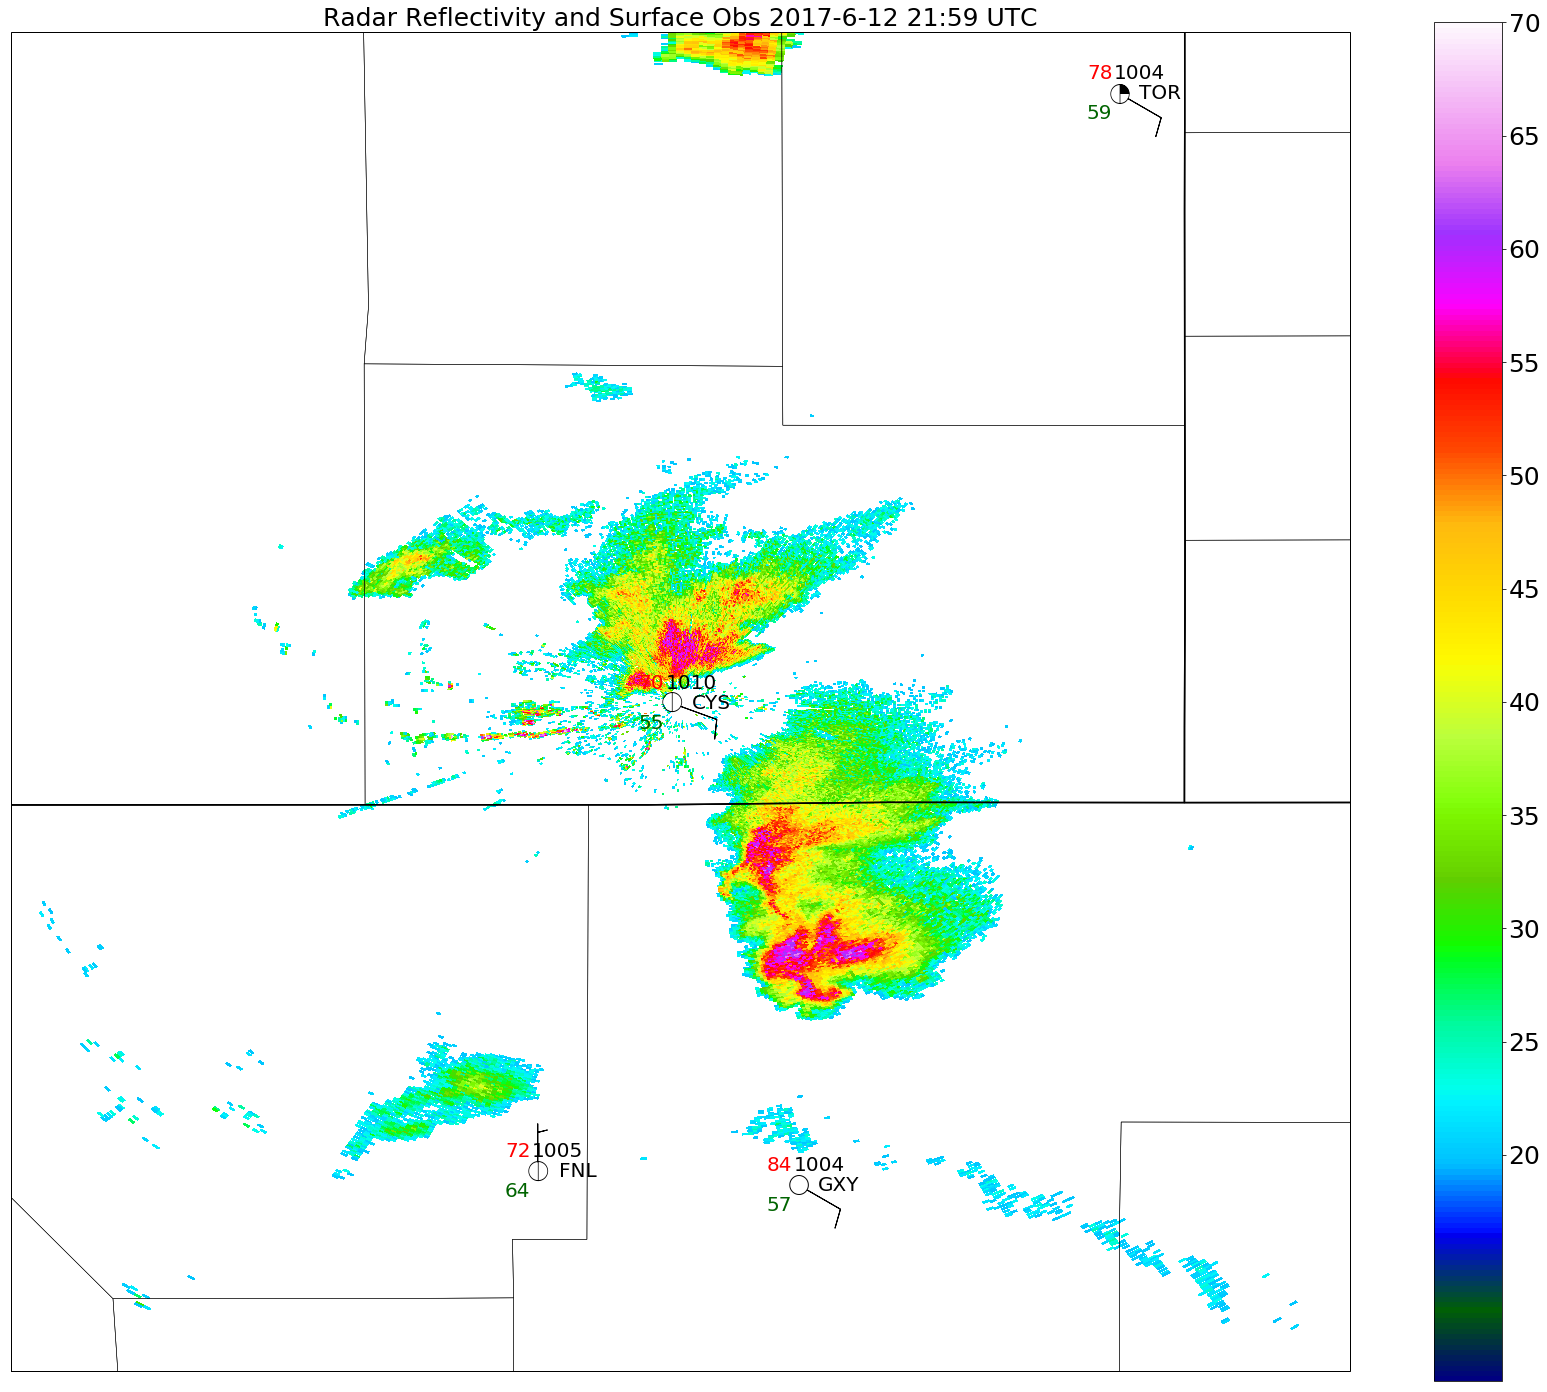

In [10]:
#Create the figure
fig=plt.figure(2,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)
# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
# Create a station plot pointing to an Axes to draw on as well as the location of points
stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=20)
stnt = stationplot.plot_parameter('NW', tair, color='red')
stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
stnpr = stationplot.plot_parameter('NE', slp)

# Add wind barbs
stnpb = stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stntx = stationplot.plot_text((2, 0), stid)
cs = plt.colorbar(refp, ticks = [20,25,30,35,40,45,50,55,60,65,70],norm=matplotlib.colors.Normalize(vmin=20, vmax=70))

cs.ax.tick_params(labelsize=25)
plt.title('Radar Reflectivity and Surface Obs '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
          ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 25)
plt.show()

In [11]:
cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/catalog.html?dataset=rap130/'+str(time_start.year)+'0'+str(time_start.month)+'/'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'/rap_130_'+str(time_start.year)+'0'+str(time_start.month)+str(time_start.day)+'_'+str(time_start.hour)+'00_001.grb2')
#cat = TDSCatalog('http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/catalog.html?dataset=rap130/'+str(year)+str(month)+'/'+str(year)+str(month)+str(day)+'/rap_130_'+str(year)+str(month)+str(day)+'_'+str(UTC)+'_000.grb2')
latest_ds = list(cat.datasets.values())[0]
print(latest_ds.access_urls)
ncss = NCSS(latest_ds.access_urls['NetcdfServer'])

C:\Users\matts\Miniconda3\envs\devel\lib\site-packages\siphon\catalog.py:71: UserWarning: URL http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/201706/20170612/catalog.html?dataset=rap130/201706/20170612/rap_130_20170612_2100_001.grb2 returned HTML. Changing to: http://nomads.ncdc.noaa.gov/thredds/catalog/rap130/201706/20170612/catalog.xml?dataset=rap130/201706/20170612/rap_130_20170612_2100_001.grb2
  new_url))


{'OPENDAP': 'http://nomads.ncdc.noaa.gov/thredds/dodsC/rap130/201706/20170612/rap_130_20170612_2100_001.grb2', 'HTTPServer': 'http://nomads.ncdc.noaa.gov/thredds/fileServer/rap130/201706/20170612/rap_130_20170612_2100_001.grb2', 'WCS': 'http://nomads.ncdc.noaa.gov/thredds/wcs/rap130/201706/20170612/rap_130_20170612_2100_001.grb2', 'WMS': 'http://nomads.ncdc.noaa.gov/thredds/wms/rap130/201706/20170612/rap_130_20170612_2100_001.grb2', 'NetcdfServer': 'http://nomads.ncdc.noaa.gov/thredds/ncss/grid/rap130/201706/20170612/rap_130_20170612_2100_001.grb2', 'NCML': 'http://nomads.ncdc.noaa.gov/thredds/ncml/rap130/201706/20170612/rap_130_20170612_2100_001.grb2', 'UDDC': 'http://nomads.ncdc.noaa.gov/thredds/uddc/rap130/201706/20170612/rap_130_20170612_2100_001.grb2', 'ISO': 'http://nomads.ncdc.noaa.gov/thredds/iso/rap130/201706/20170612/rap_130_20170612_2100_001.grb2'}


In [12]:
query = ncss.query()
query.variables('Convective_available_potential_energy_surface').variables('U-component_of_wind').variables('V-component_of_wind').variables('Storm_relative_helicity').variables('Pressure_surface').variables('Dew_point_temperature').variables('Temperature_height_above_ground').variables('Vertical_u-component_shear').variables('Vertical_v-component_shear').variables('Geopotential_height').variables('Geopotential_height_surface')
query.add_lonlat().lonlat_box(cenlon-1.1, cenlon +1.1, cenlat-1.1, cenlat+1.1)
data1 = ncss.get_data(query)
dtime = data1.variables['Convective_available_potential_energy_surface'].dimensions[0]
dlat = data1.variables['Convective_available_potential_energy_surface'].dimensions[1]
dlev = data1.variables['Geopotential_height'].dimensions[1]
dlon = data1.variables['Convective_available_potential_energy_surface'].dimensions[2]
CAPE = data1.variables['Convective_available_potential_energy_surface'][:] * units('J/kg')
SRH = data1.variables['Storm_relative_helicity'][:] * units('m/s')
SFCP = (data1.variables['Pressure_surface'][:]/100.) * units('hPa')
Td = data1.variables['Dew_point_temperature'][:] * units('kelvin')
T = data1.variables['Temperature_height_above_ground'][:] * units('kelvin')
ushr = data1.variables['Vertical_u-component_shear'][:] * units('m/s')
vshr = data1.variables['Vertical_v-component_shear'][:] * units('m/s')
hgt = data1.variables['Geopotential_height'][:] * units('meter')
sfc_hgt = data1.variables['Geopotential_height_surface'][:] * units('meter')
uwnd = data1.variables['U-component_of_wind'][:] * units('m/s')
vwnd = data1.variables['V-component_of_wind'][:] * units('m/s')

# Get the dimension data
lats_r = data1.variables[dlat][:]
lons_r= data1.variables[dlon][:]
lev = (data1.variables[dlev][:]/100.) * units('hPa')

In [13]:
# Set up our array of latitude and longitude values and transform to 
# the desired projection.
crs = ccrs.PlateCarree()
crlons, crlats = np.meshgrid(lons_r[:]*1000, lats_r[:]*1000)
trlatlons = crs.transform_points(ccrs.LambertConformal(central_longitude=265, central_latitude=25, standard_parallels=(25.,25.)),crlons,crlats)
trlons = trlatlons[:,:,0]
trlats = trlatlons[:,:,1]

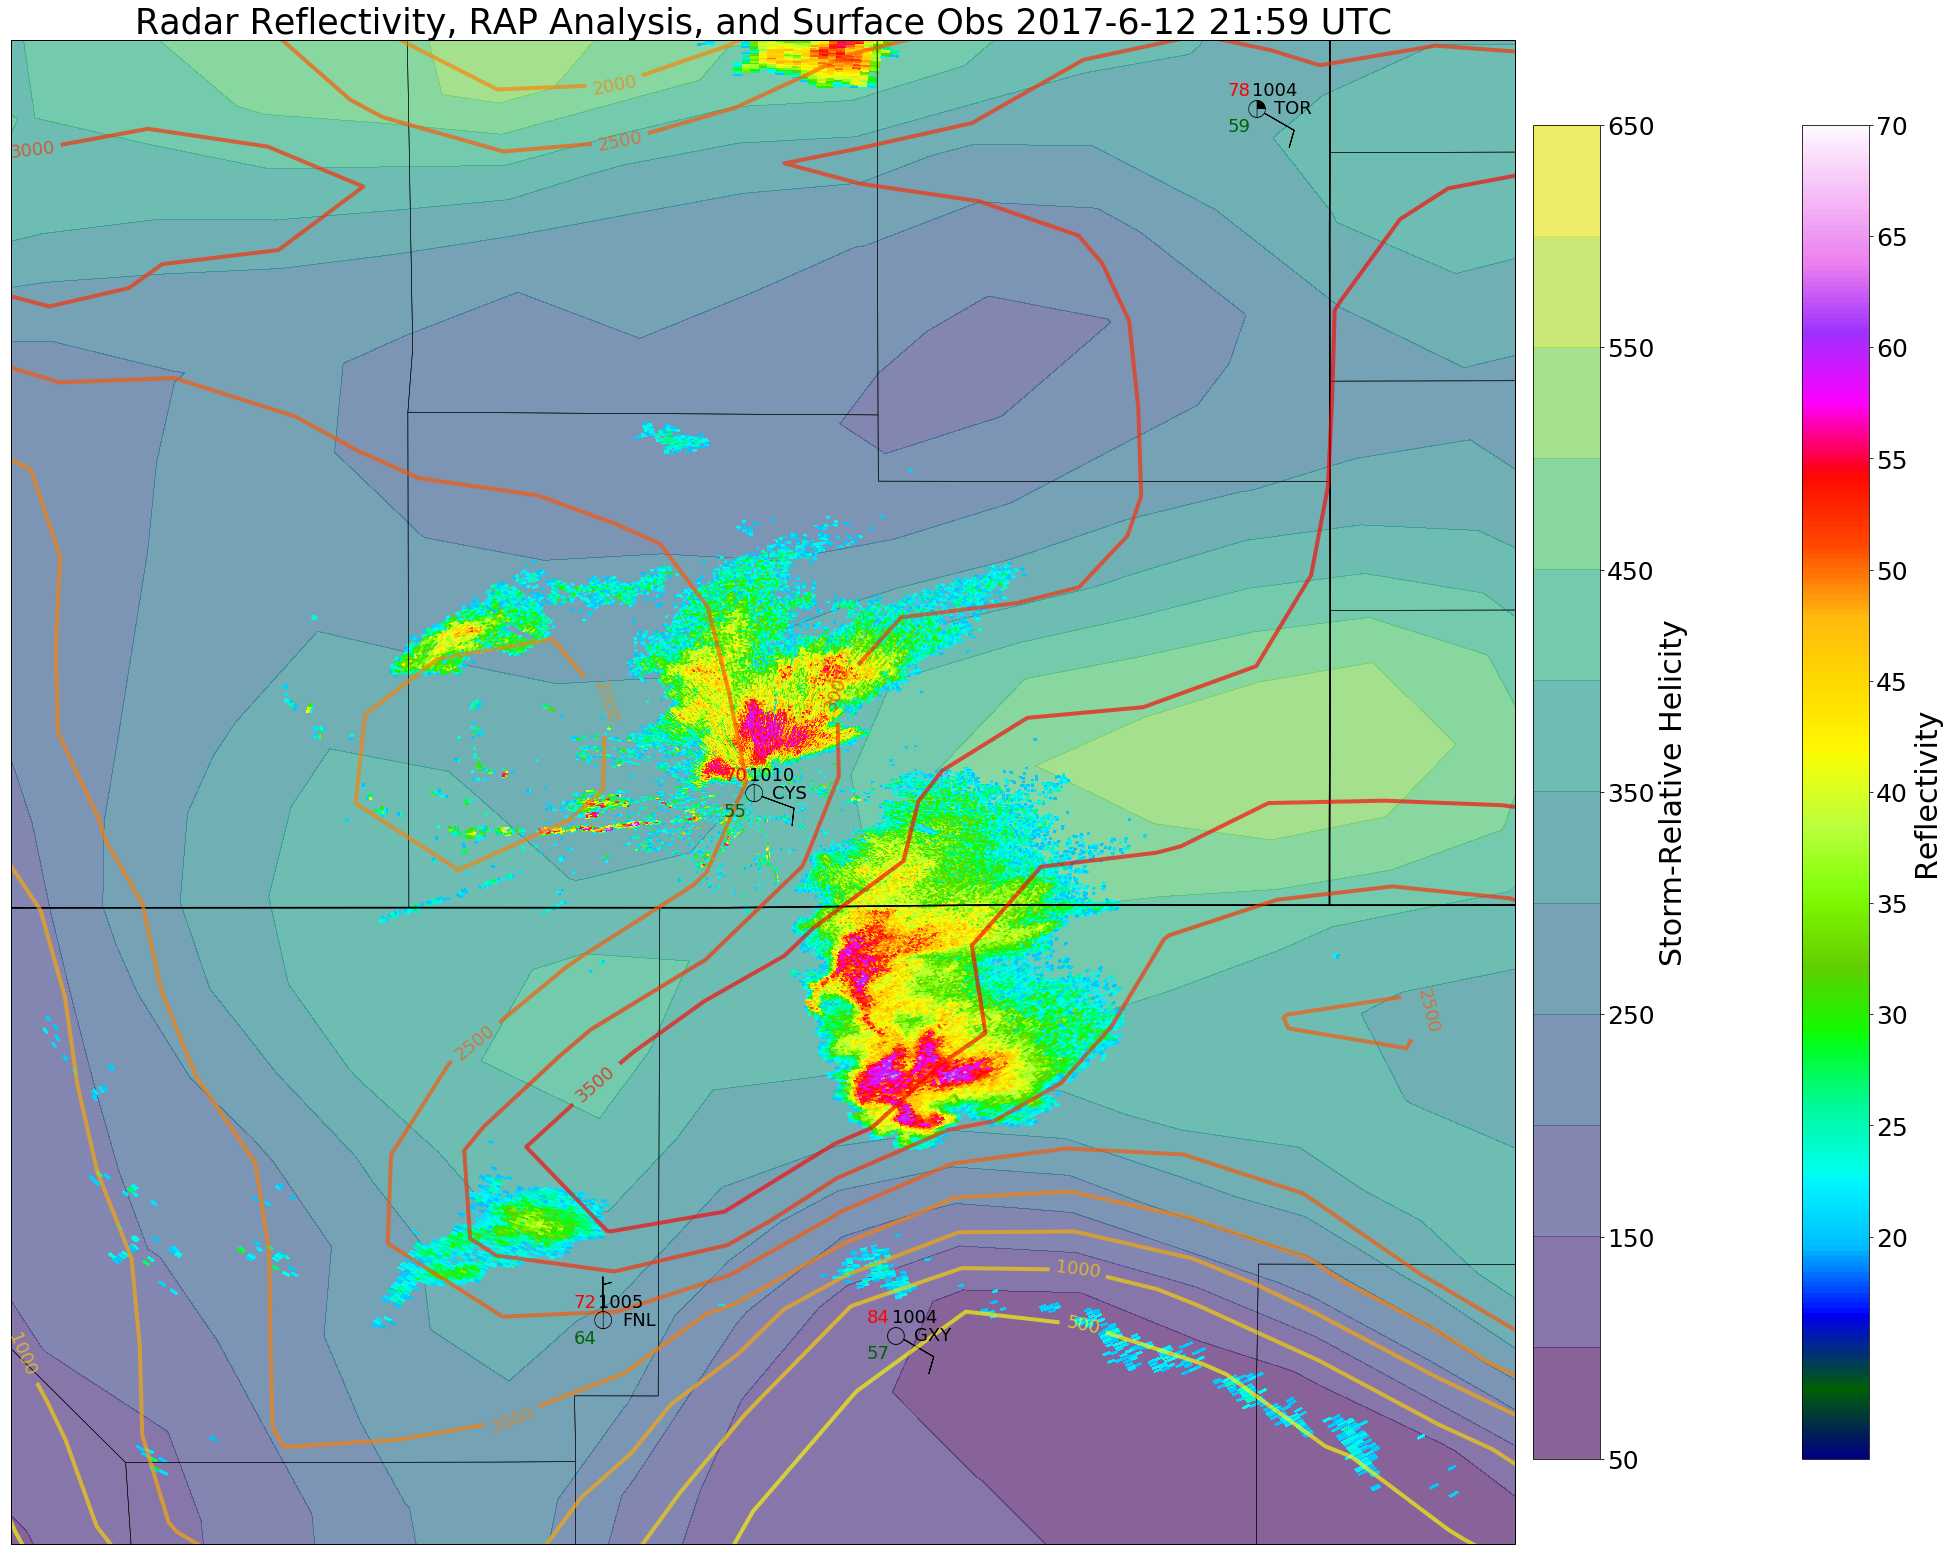

In [14]:
#Create the figure
fig=plt.figure(2,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
srhlev = np.arange(50,700,50)
ch = ax.contourf(trlons, trlats, SRH[0,1,:,:], srhlev, cmap=plt.cm.viridis, alpha = .65)
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)
# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
# Create a station plot pointing to an Axes to draw on as well as the location of points
stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=18)
stnt = stationplot.plot_parameter('NW', tair, color='red')
stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
stnpr = stationplot.plot_parameter('NE', slp)

# Add wind barbs
stnpb = stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stntx = stationplot.plot_text((2, 0), stid)

#Plot CAPE because why not
cplev = np.arange(500,4000,500)
cf = ax.contour(trlons, trlats, CAPE[0,:,:], cplev, cmap=plt.cm.autumn_r, linewidths = 4, alpha = .65)
#ch = ax.contourf(trlons, trlats, SRH[0,1,:,:], srhlev, cmap=plt.cm.BuPu, alpha = .65)

plt.clabel(cf, fontsize=18, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

cs = plt.colorbar(refp, ticks = [20,25,30,35,40,45,50,55,60,65,70],norm=matplotlib.colors.Normalize(vmin=20, vmax=70),
                  shrink = .75, pad = 0)
cg = plt.colorbar(ch, shrink = .75, pad = .01)
cg.ax.tick_params(labelsize=25)
cg.set_label("Storm-Relative Helicity",size = 30)
cs.ax.tick_params(labelsize=25)
cs.set_label("Reflectivity",size = 30)
plt.title('Radar Reflectivity, RAP Analysis, and Surface Obs '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
          ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 35)
plt.tight_layout()
plt.savefig("ReallyCoolMap.png")
plt.show()

In [15]:
from metpy.calc import lcl, log_interp

In [16]:
levs = np.zeros((hgt.shape[1], hgt.shape[2], hgt.shape[3]))
for i in range(hgt.shape[2]):
    for j in range(hgt.shape[3]):
        levs[:,i,j] = lev

In [17]:
SHR6 = np.sqrt(ushr ** 2 + vshr ** 2)

In [18]:
lcl_rap = lcl(SFCP[0,:,:], T[0,0,:,:], Td[0,0,:,:])

In [19]:
lcl_h = log_interp(lcl_rap[0], levs * units('hPa'), hgt[0,:,:,:], axis = 0)

In [20]:
print(lcl_h.shape)
print(lcl_rap[0].shape)

(357, 21, 17)
(21, 17)


In [21]:
lcl_h = np.zeros((lcl_rap[0].shape))
for i in range(lcl_rap[0].shape[0]):
    for j in range(lcl_rap[0].shape[1]):
        lcl_h[i,j] = (log_interp(lcl_rap[0][i,j], levs[:,i,j] * units('hPa'), hgt[0,:,i,j])).magnitude

In [22]:

lcl_agl = lcl_h * units('meter')-sfc_hgt[0,:,:]

In [23]:
def sigtor(sbcape, sblcl, srh1, shr6):
    r"""Calculate the significant tornado parameter (fixed layer).
     
    The significant tornado parameter is designed to identify
    environments favorable for the production of significant
    tornadoes contingent upon the development of supercells.
    It's calculated according to the formula used on the SPC
    mesoanalysis page, updated in [Thompson, Edwards, and Mead, 2004]:
    
    sigtor = (sbcape / 1500 J/kg) * ((2000 m - sblcl) / 1000 m) * (srh1 / 150 m^s/s^2) * (shr6 / 20 m/s)
    
    The sblcl term is set to zero when the lcl is above 2000m and 
    capped at 1 when below 1000m, and the shr6 term is set to 0 
    when shr6 is below 12.5 m/s and maxed out at 1.5 when shr6
    exceeds 30 m/s.
    
    Parameters
    ----------
    sbcape : array-like
        Surface-based CAPE
    sblcl : array-like
        Surface-based lifted condensation level
    srh1 : array-like
        Surface-1km storm-relative helicity
    shr6 : array-like
        Surface-6km bulk shear
        
    Returns
    -------
    number
        significant tornado parameter
    
    Citation:
    Thompson, R.L., R. Edwards, and C. M. Mead, 2004b:
        An update to the supercell composite
        and significant tornado parameters.
        Preprints, 22nd Conf. on Severe Local
        Storms, Hyannis, MA, Amer.
        Meteor. Soc.
        
    """
    
    shr6 = shr6.to('m/s')
    shr6 = shr6.magnitude
    sblcl = sblcl.magnitude
    ind = np.where((sblcl <= 2000.) & (sblcl >= 1000.))
    ind1 = np.where(sblcl < 1000.)
    ind2 = np.where(sblcl > 2000.)
    sind = np.where((shr6 <= 30.) & (shr6 >= 12.5))
    sind1 = np.where(shr6 < 12.5)
    sind2 = np.where(shr6 > 30.)
    sblcl[ind] = (2000. - sblcl[ind]) / 1000.
    sblcl[ind1] = 1.
    sblcl[ind2] = 0.
    shr6[sind] = shr6[sind] / 20.
    shr6[sind1] = 0.
    shr6[sind2] = 1.5
    sigtor = (sbcape.magnitude / 1500.) * sblcl * (srh1.magnitude / 150.) * shr6
     
    return sigtor

In [24]:
sigtor_p = sigtor(CAPE[0,:,:], lcl_agl, SRH[0,0,:,:], SHR6[0,0,:,:])

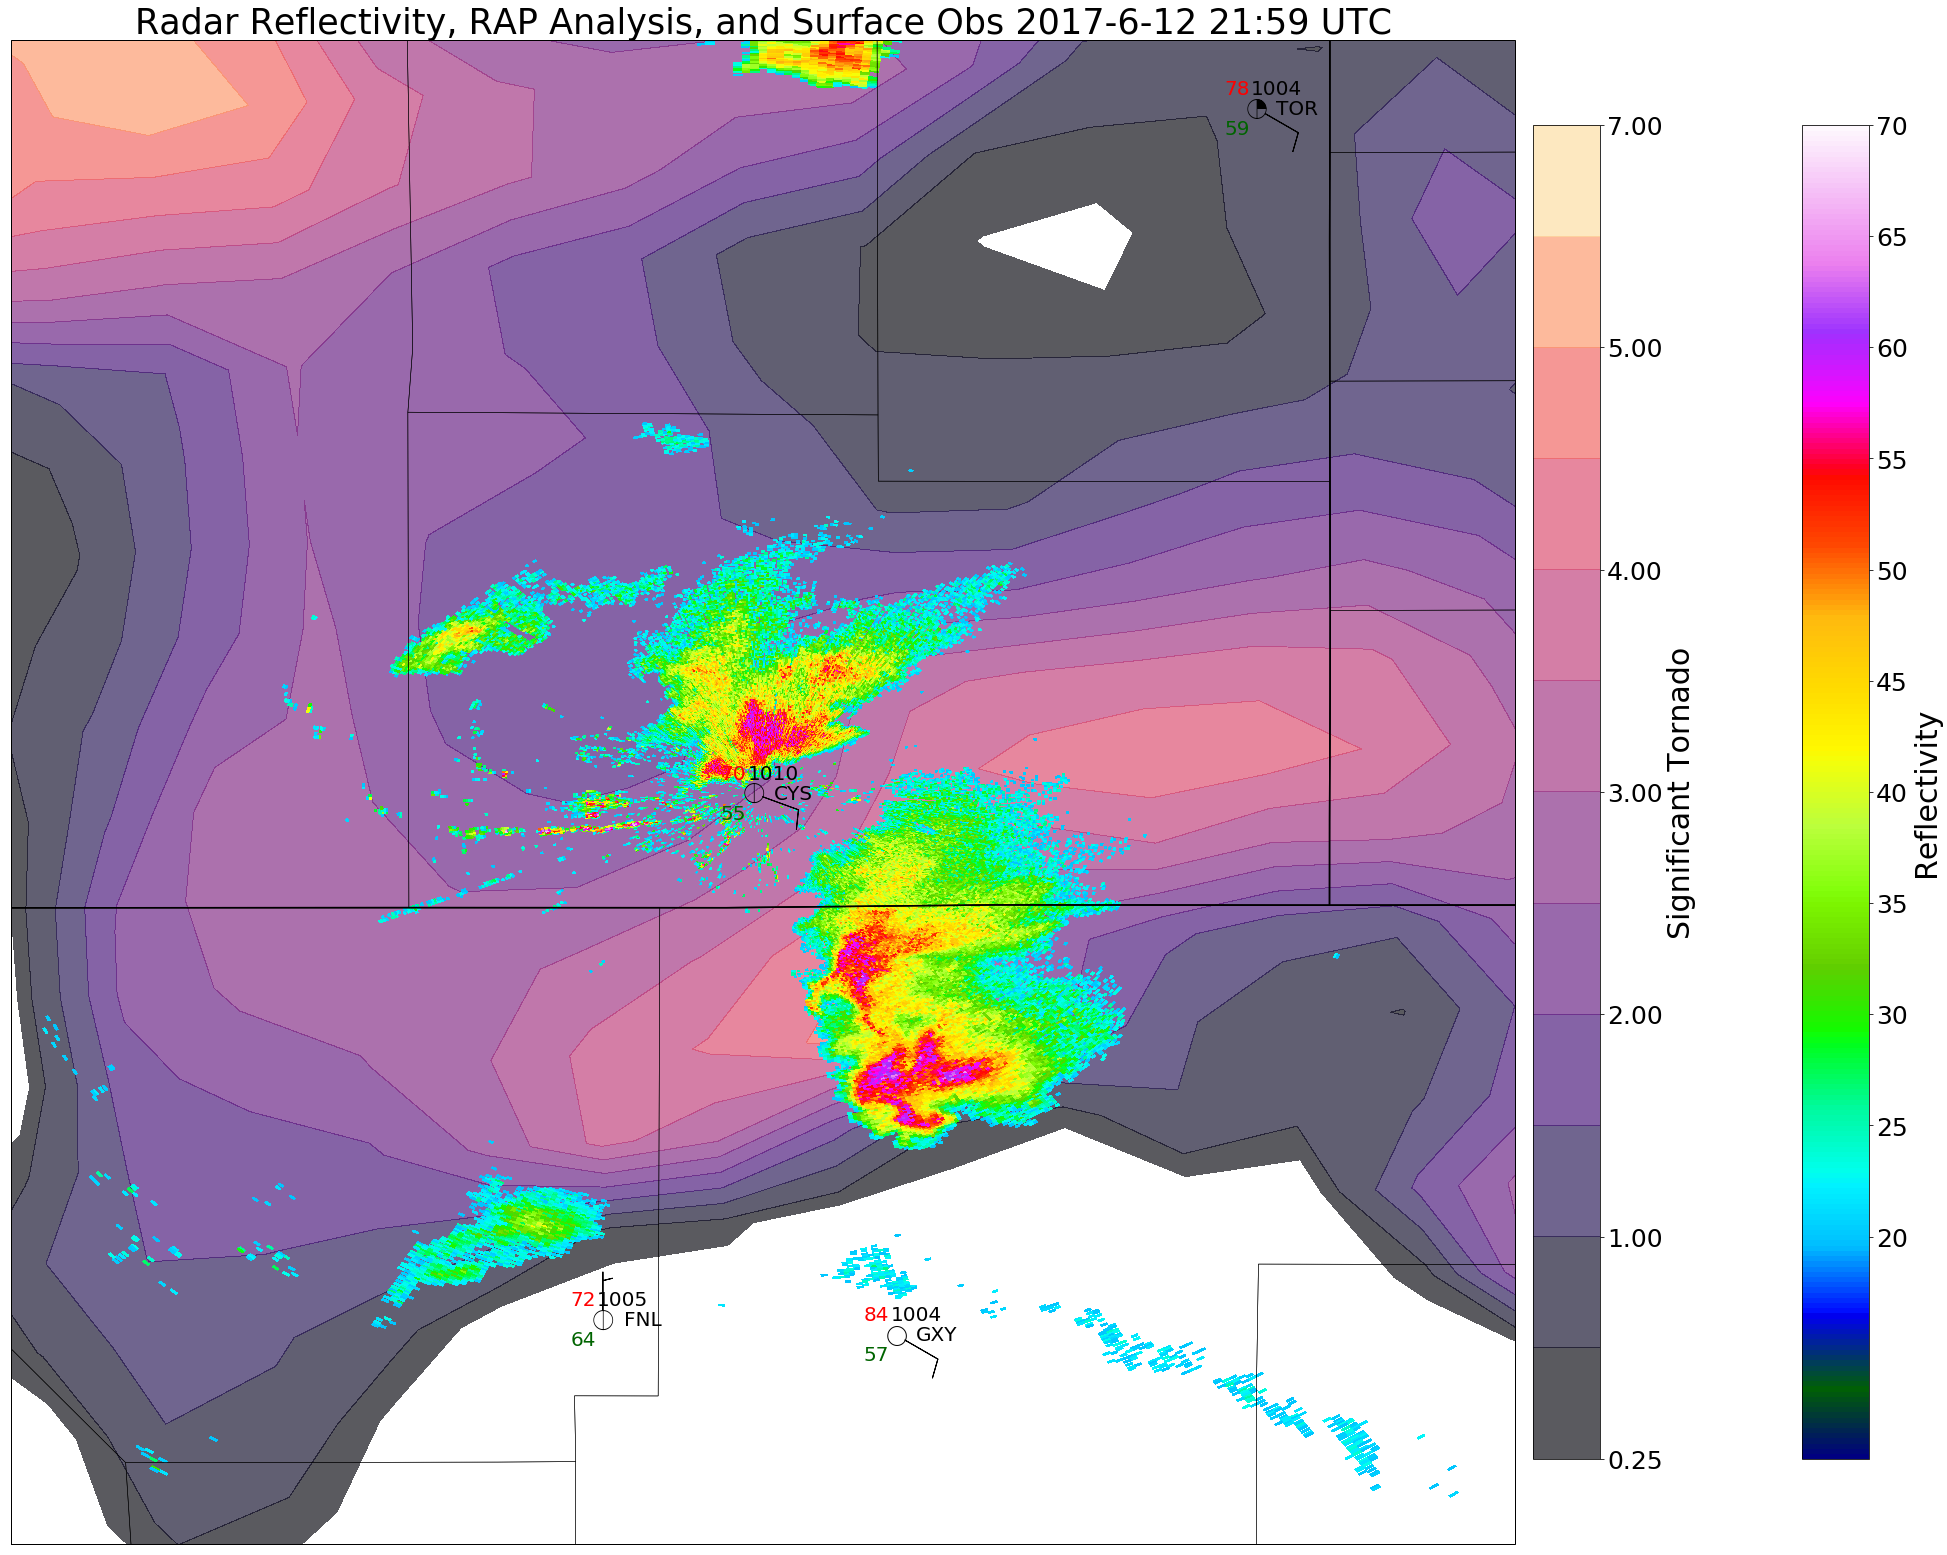

In [25]:
#Create the figure
fig=plt.figure(2,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
stlev = [.25,.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7]
ch = ax.contourf(trlons, trlats, sigtor_p, stlev, cmap=plt.cm.magma, alpha = .65)
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)
# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
# Create a station plot pointing to an Axes to draw on as well as the location of points
stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=20)
stnt = stationplot.plot_parameter('NW', tair, color='red')
stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
stnpr = stationplot.plot_parameter('NE', slp)

# Add wind barbs
stnpb = stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stntx = stationplot.plot_text((2, 0), stid)

#Plot CAPE because why not
cplev = np.arange(500,4000,500)
#cf = ax.contour(trlons, trlats, CAPE[0,:,:], cplev, cmap=plt.cm.autumn_r, linewidths = 4, alpha = .65)
#ch = ax.contourf(trlons, trlats, SRH[0,1,:,:], srhlev, cmap=plt.cm.BuPu, alpha = .65)

#plt.clabel(cf, fontsize=16, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

cs = plt.colorbar(refp, ticks = [20,25,30,35,40,45,50,55,60,65,70],norm=matplotlib.colors.Normalize(vmin=20, vmax=70),
                  shrink = .75, pad = 0)
cg = plt.colorbar(ch, shrink = .75, pad = .01)
cg.ax.tick_params(labelsize=25)
cg.set_label("Significant Tornado",size = 30)
cs.ax.tick_params(labelsize=25)
cs.set_label("Reflectivity",size = 30)
plt.title('Radar Reflectivity, RAP Analysis, and Surface Obs '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
          ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 35)
plt.tight_layout()
plt.savefig("SigTorMap.png")
plt.show()

In [26]:
def bulk_shear(u, v, pressure, height, top, bottom = None):
    r"""Calculate bulk shear through a layer. 
    
    Layer top and bottom specified in meters AGL:
    
    Parameters
    ----------
    u : array-like
        U-component of wind.
    v : array-like
        V-component of wind.
    p : array-like
        Atmospheric pressure profile
    hgt : array-like
        Heights from sounding
    top: `pint.Quantity`
        The top of the layer in meters AGL
    bottom: `pint.Quantity`
        The bottom of the layer in meters AGL.
        Default is the surface.
        
    Returns
    -------
    `pint.Quantity'
        u_shr: u-component of layer bulk shear, in m/s
    `pint.Quantity'
        v_shr: v-component of layer bulk shear, in m/s
    `pint.Quantity'
        shr_mag: magnitude of layer bulk shear, in m/s
        
    """   
    
    
    u = u.to('meters/second')
    v = v.to('meters/second')
    
    sort_inds = np.argsort(pressure[::-1])
    pressure = pressure[sort_inds]
    height = height[sort_inds]
    u = u[sort_inds]
    v = v[sort_inds]
    
    if bottom:
        depth_s = top - bottom
        bottom = bottom + height[0]
    else:
        depth_s = top
        
    w_int = get_layer(pressure, u, v, heights=height, bottom=bottom, depth=depth_s)
    
    u_shr = w_int[1][-1] - w_int[1][0]
    v_shr = w_int[2][-1] - w_int[2][0]
    
    shr_mag = np.sqrt((u_shr ** 2) + (v_shr ** 2))
    
    return u_shr, v_shr, shr_mag


In [27]:
height_agl = hgt - sfc_hgt

In [28]:
print(np.max(sfc_hgt))
print(hgt.shape)

3258.42529296875 meter
(1, 37, 21, 17)


In [29]:
print(uwnd)

[[[[  3.84427929   2.84427929   1.90677929 ...,  -1.96822071  -3.09322071     -3.96822071]   [  3.46927929   2.28177929   1.15677929 ...,  -2.96822071  -3.84322071     -4.53072071]   [  3.09427929   1.71927929   0.53177929 ...,  -4.03072071  -4.53072071     -4.78072071]   ...,    [ -8.21822071  -8.71822071  -8.53072071 ...,  -6.34322071  -6.34322071     -6.40572071]   [ -9.15572071  -9.28072071  -8.84322071 ...,  -6.21822071  -6.28072071     -6.34322071]   [ -9.59322071  -9.46822071  -8.90572071 ...,  -6.28072071  -6.40572071     -6.59322071]]  [[  3.88532734   2.82282734   1.88532734 ...,  -1.92717266  -3.05217266     -3.98967266]   [  3.51032734   2.26032734   1.13532734 ...,  -2.98967266  -3.86467266     -4.55217266]   [  3.13532734   1.76032734   0.51032734 ...,  -4.05217266  -4.55217266     -4.80217266]   ...,    [ -8.23967266  -8.73967266  -8.48967266 ...,  -6.42717266  -6.36467266     -6.42717266]   [ -9.11467266  -9.30217266  -8.92717266 ...,  -6.23967266  -6.23967266     -6.30

In [30]:
sfc1_u = np.zeros((lcl_rap[0].shape))
sfc1_v = np.zeros((lcl_rap[0].shape))
for i in range(lcl_rap[0].shape[0]):
    for j in range(lcl_rap[0].shape[1]):
        shr1 = bulk_shear(uwnd[0,:,i,j], vwnd[0,:,i,j], levs[:,i,j] * units('hPa'), height_agl[0,:,i,j], top = 1000 * units('meter'), bottom = 0 * units('meter'))
        sfc1_u[i,j] = shr1[0].magnitude
        sfc1_v[i,j] = shr1[1].magnitude

In [31]:
sfc1_u = (sfc1_u * units('m/s')).to('knot')
sfc1_v = (sfc1_v * units('m/s')).to('knot')


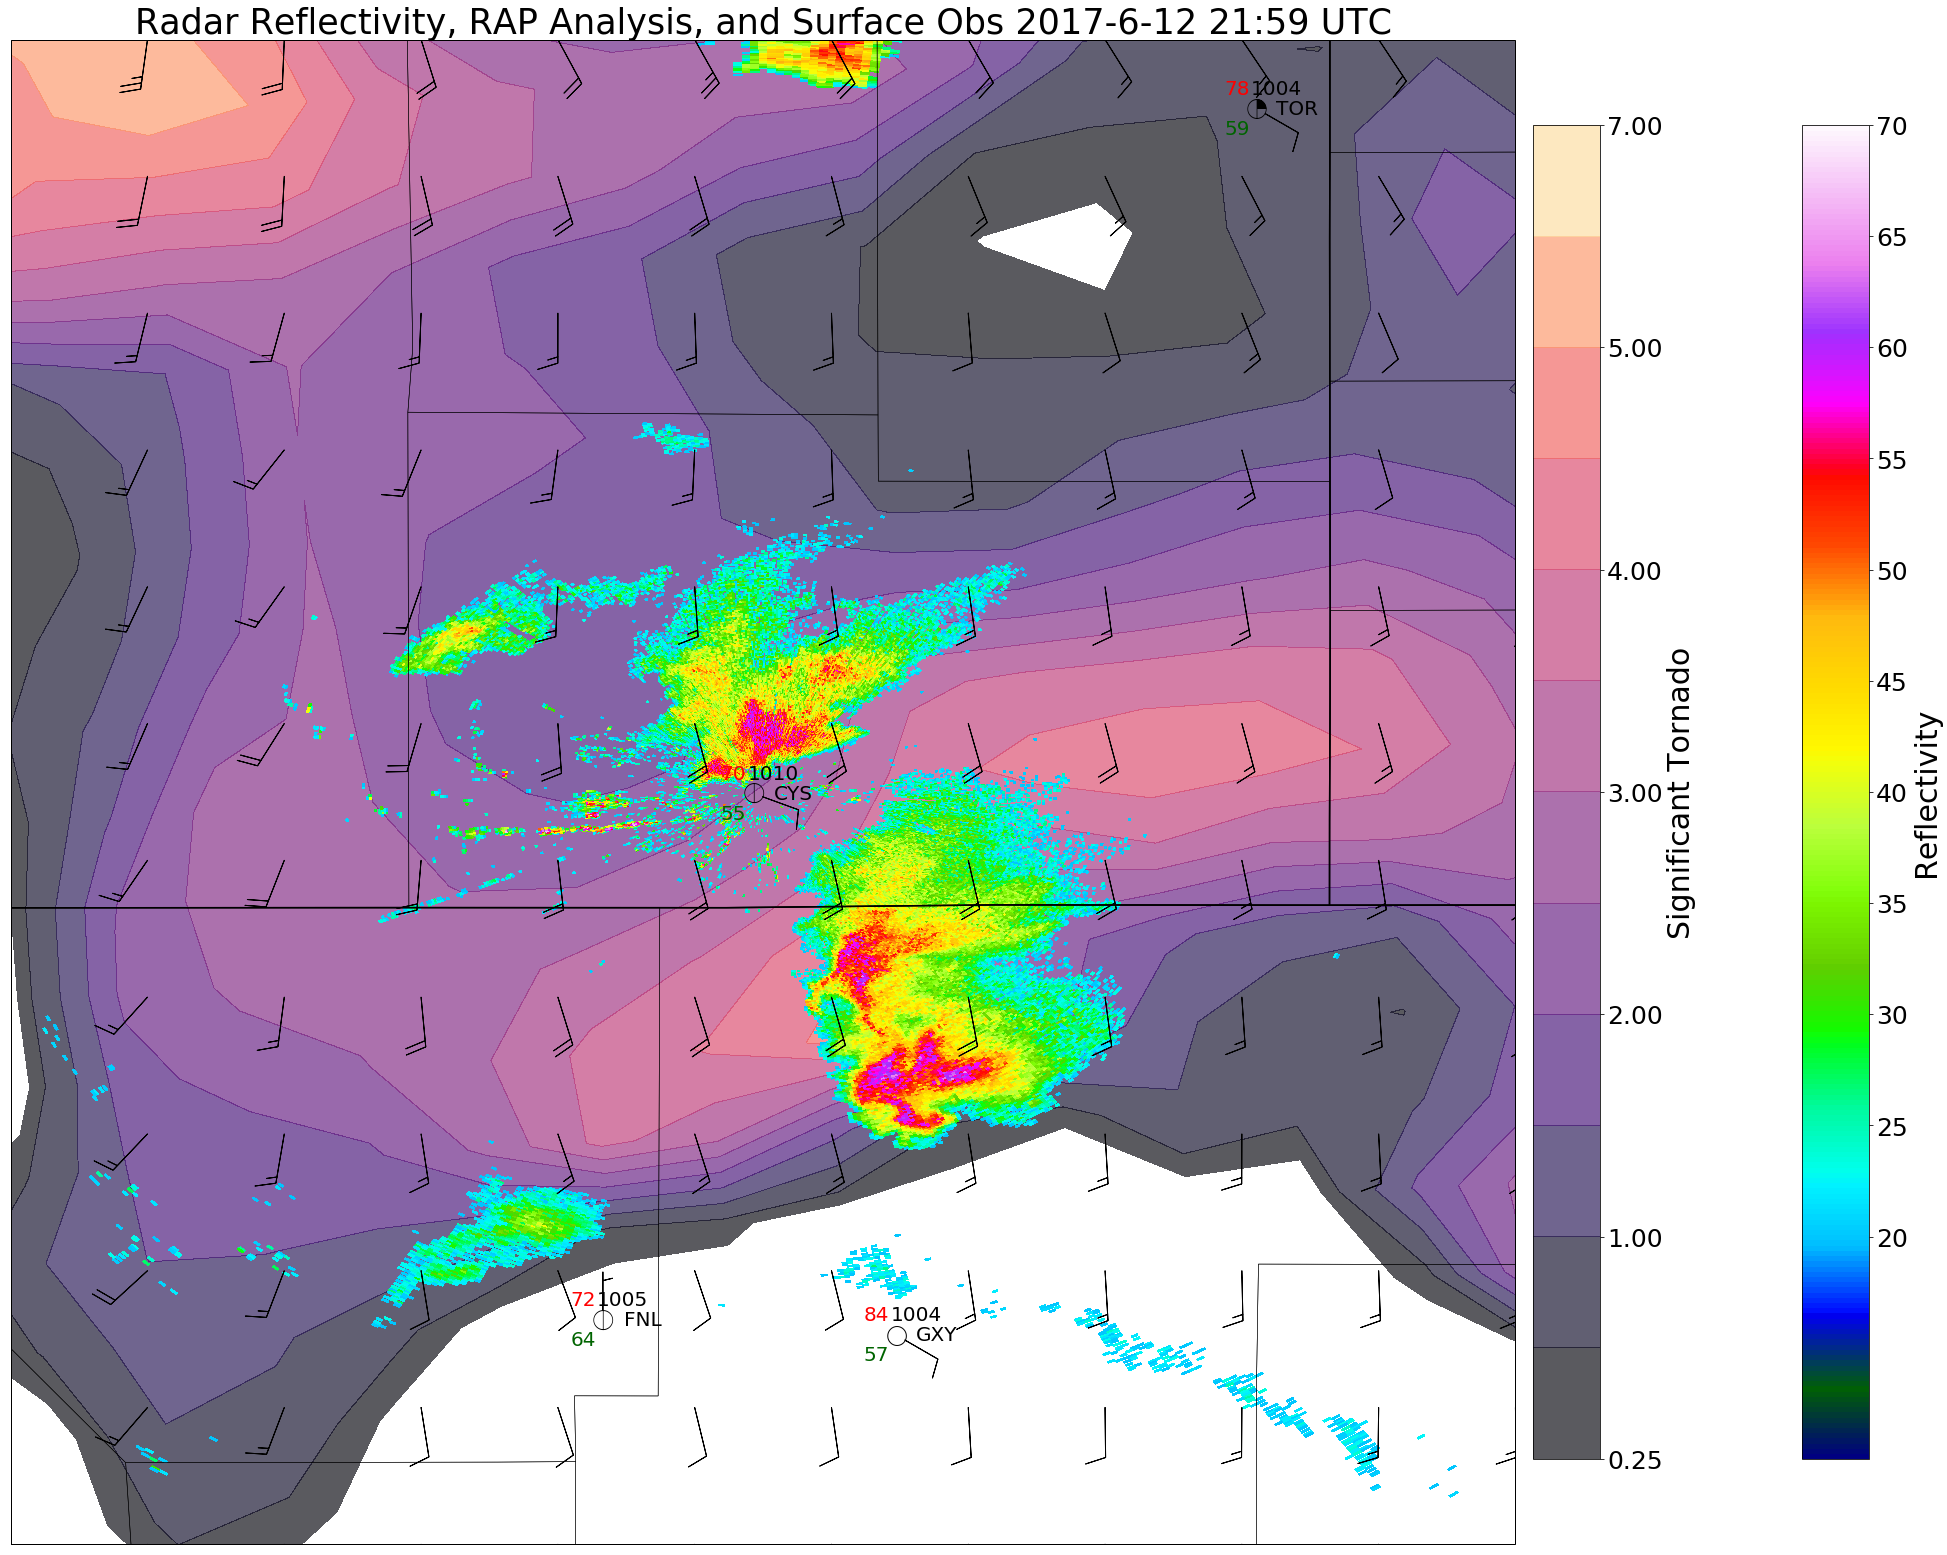

In [32]:
#Create the figure
fig=plt.figure(2,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
stlev = [.25,.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7]
ch = ax.contourf(trlons, trlats, sigtor_p, stlev, cmap=plt.cm.magma, alpha = .65)
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)
# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
# Create a station plot pointing to an Axes to draw on as well as the location of points
stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=20)
stnt = stationplot.plot_parameter('NW', tair, color='red')
stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
stnpr = stationplot.plot_parameter('NE', slp)

# Add wind barbs
stnpb = stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stntx = stationplot.plot_text((2, 0), stid)

#Plot CAPE because why not
cplev = np.arange(500,4000,500)
#cf = ax.contour(trlons, trlats, CAPE[0,:,:], cplev, cmap=plt.cm.autumn_r, linewidths = 4, alpha = .65)
#ch = ax.contourf(trlons, trlats, SRH[0,1,:,:], srhlev, cmap=plt.cm.BuPu, alpha = .65)

#plt.clabel(cf, fontsize=16, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

cs = plt.colorbar(refp, ticks = [20,25,30,35,40,45,50,55,60,65,70],norm=matplotlib.colors.Normalize(vmin=20, vmax=70),
                  shrink = .75, pad = 0)
cg = plt.colorbar(ch, shrink = .75, pad = .01)
cg.ax.tick_params(labelsize=25)
cg.set_label("Significant Tornado",size = 30)
cs.ax.tick_params(labelsize=25)
cs.set_label("Reflectivity",size = 30)
ax.barbs(trlons,trlats,sfc1_u,sfc1_v,length=10,regrid_shape=12, color = 'k')
plt.title('Radar Reflectivity, RAP Analysis, and Surface Obs '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
          ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 35)
plt.tight_layout()
plt.savefig("SigTorShearMap.png")
plt.show()

In [33]:
tors = np.genfromtxt('June12Tornadoes.csv', usecols =(0,1), delimiter = ',')
torlats = tors[:,0]/100.
torlons = tors[:,1]/-100.

In [34]:
print(torlats)
print(torlons)

[ 42.16  41.26  40.97  41.    41.03  41.1   41.03  42.33  41.19  42.47
  43.71  44.42  41.36  41.33  41.48  41.38  41.37  44.14  43.65  41.35
  44.45  41.45  42.93  41.58  41.63  41.81  42.55  41.98  41.91  42.08
  42.13  43.2 ]
[-104.65 -104.64 -104.3  -104.31 -104.31 -104.34 -104.13 -104.1  -104.05
 -103.88 -106.64 -108.91 -103.89 -103.89 -103.84 -103.89 -103.73 -108.42
  -88.2  -103.89 -108.51 -103.66 -106.39 -103.7  -103.63 -103.29 -105.67
 -102.87 -102.87 -102.67 -102.62 -102.03]


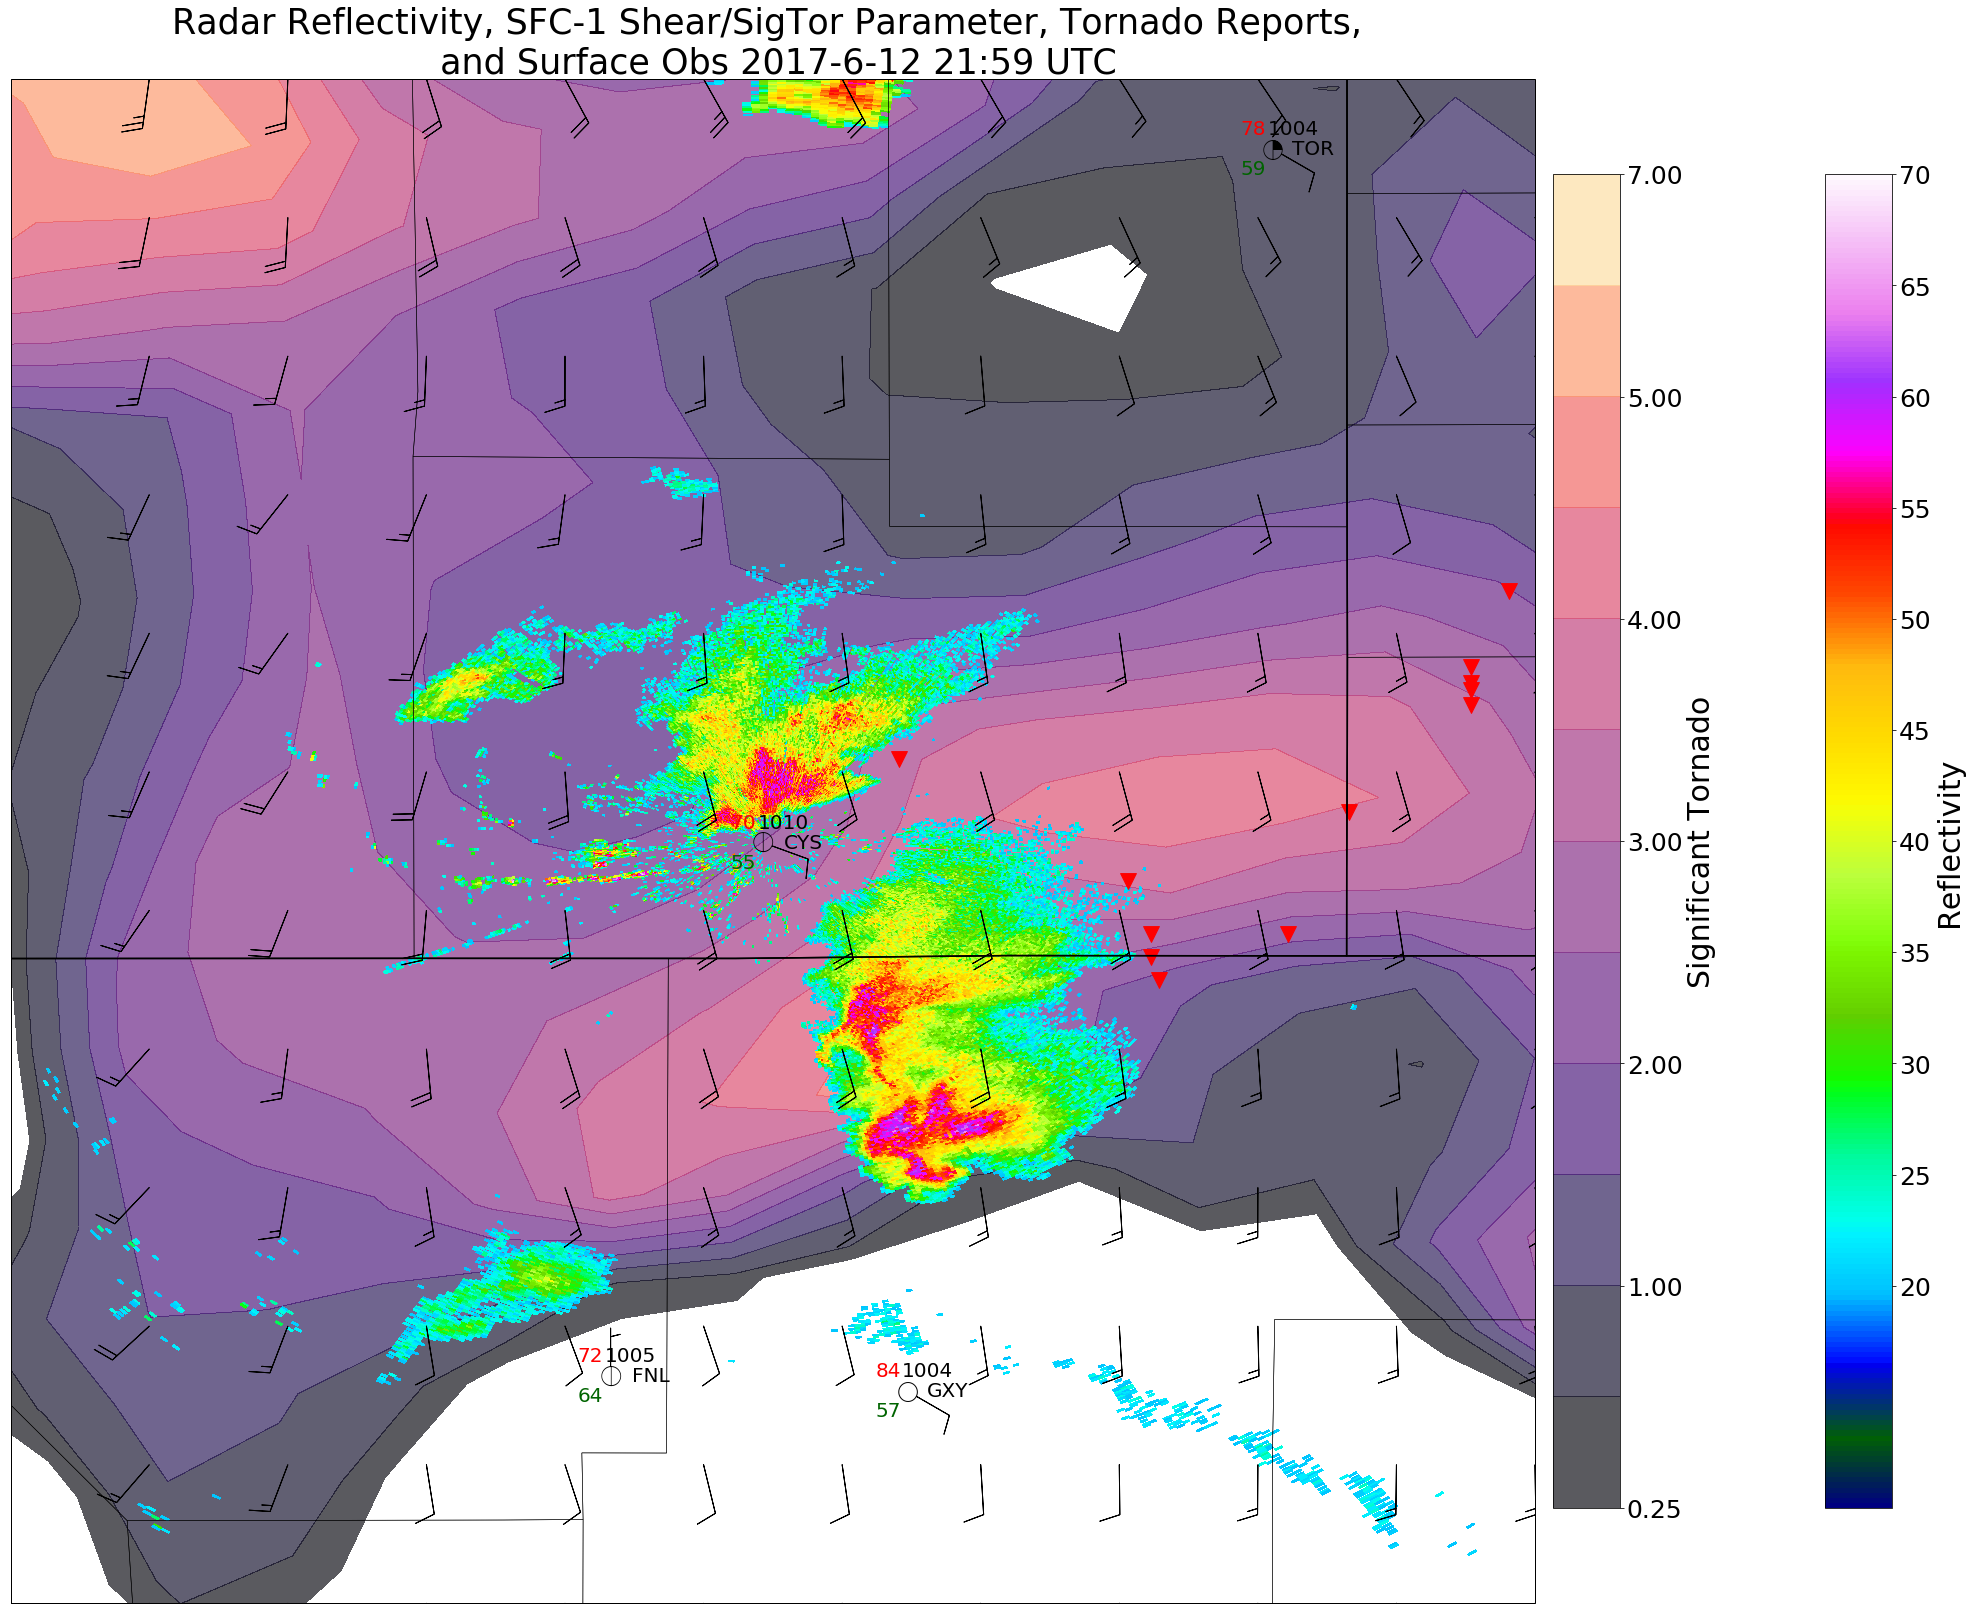

In [35]:
#Create the figure
fig=plt.figure(2,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
stlev = [.25,.5,1,1.5,2,2.5,3,3.5,4,4.5,5,6,7]
ch = ax.contourf(trlons, trlats, sigtor_p, stlev, cmap=plt.cm.magma, alpha = .65)
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)
# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
# Create a station plot pointing to an Axes to draw on as well as the location of points
stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=20)
stnt = stationplot.plot_parameter('NW', tair, color='red')
stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
stnpr = stationplot.plot_parameter('NE', slp)

# Add wind barbs
stnpb = stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stntx = stationplot.plot_text((2, 0), stid)

#Plot CAPE because why not
cplev = np.arange(500,4000,500)
#cf = ax.contour(trlons, trlats, CAPE[0,:,:], cplev, cmap=plt.cm.autumn_r, linewidths = 4, alpha = .65)
#ch = ax.contourf(trlons, trlats, SRH[0,1,:,:], srhlev, cmap=plt.cm.BuPu, alpha = .65)

#plt.clabel(cf, fontsize=16, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

cs = plt.colorbar(refp, ticks = [20,25,30,35,40,45,50,55,60,65,70],norm=matplotlib.colors.Normalize(vmin=20, vmax=70),
                  shrink = .75, pad = 0)
cg = plt.colorbar(ch, shrink = .75, pad = .01)
cg.ax.tick_params(labelsize=25)
cg.set_label("Significant Tornado",size = 30)
cs.ax.tick_params(labelsize=25)
cs.set_label("Reflectivity",size = 30)
ax.barbs(trlons,trlats,sfc1_u,sfc1_v,length=10,regrid_shape=12, color = 'k')
ax.scatter(torlons, torlats, s = 250, color = 'r', marker = 'v')
plt.title('Radar Reflectivity, SFC-1 Shear/SigTor Parameter, Tornado Reports, \n and Surface Obs '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
          ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 35)
plt.tight_layout()
plt.savefig("SigTorwReportsMap.png")
plt.show()

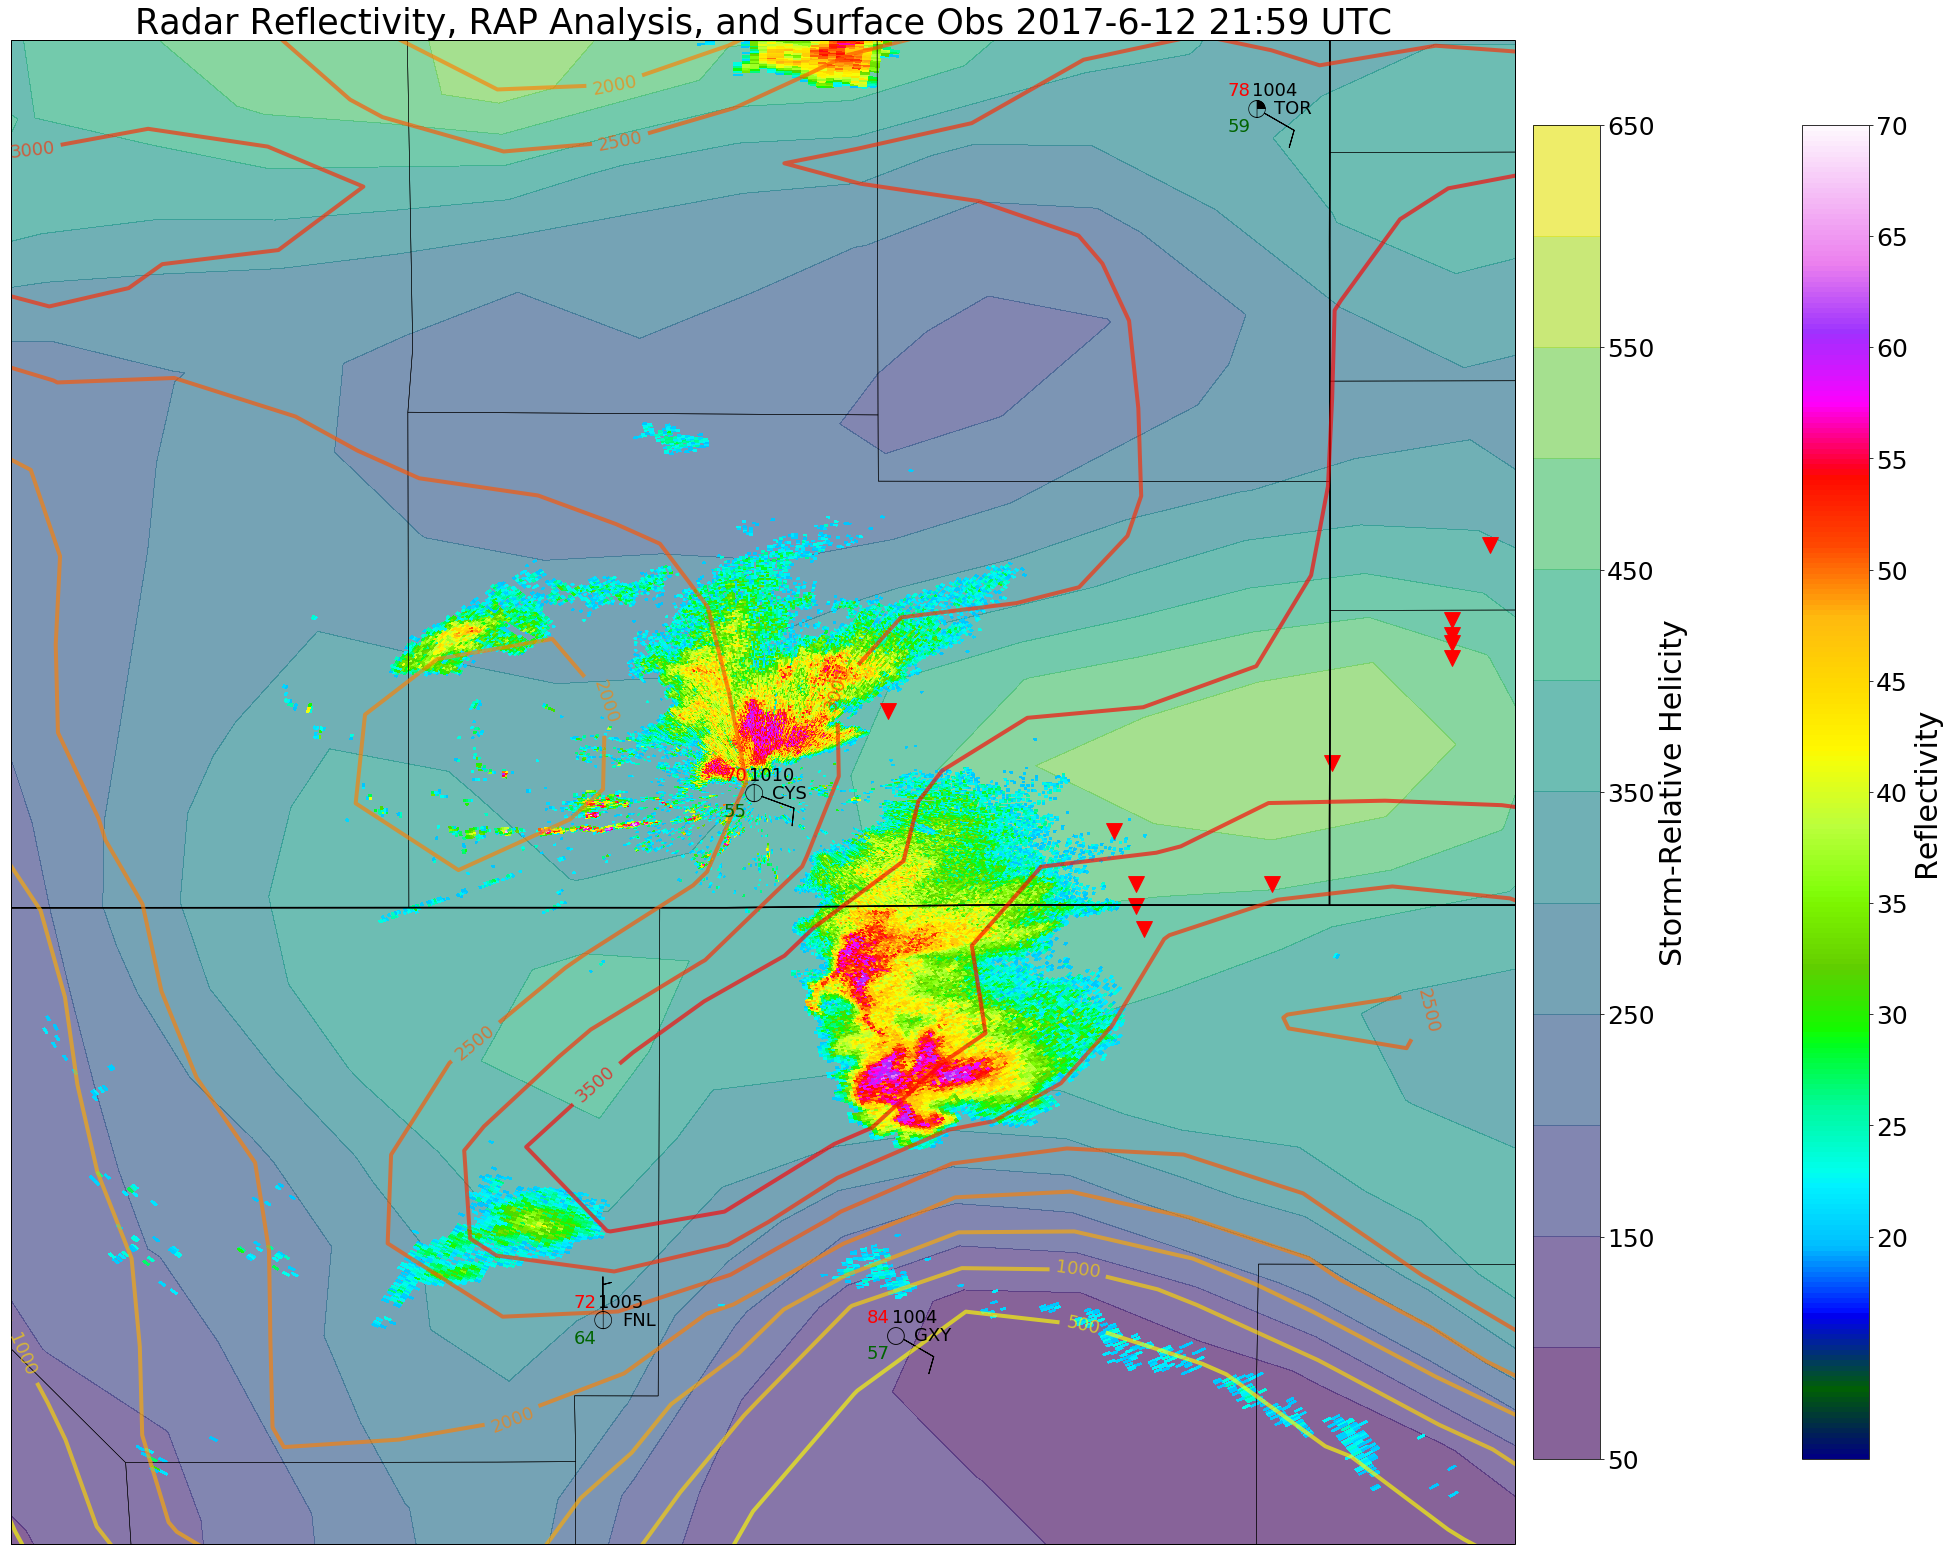

In [36]:
#Create the figure
fig=plt.figure(2,figsize=(30.,25.))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines('50m',edgecolor='black',linewidth=0.75)
#ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
#Add states/counties and set extent
ax.add_feature(counties, edgecolor = 'black', linewidth = 0.5)
ax.add_feature(states, edgecolor = 'black', linewidth = 1.5)
ax.set_extent([LL[0],UR[0],LL[1],UR[1]])
srhlev = np.arange(50,700,50)
ch = ax.contourf(trlons, trlats, SRH[0,1,:,:], srhlev, cmap=plt.cm.viridis, alpha = .65)
#Plot our radar data
refp = ax.pcolormesh(rlons, rlats, refl, cmap=plt.cm.gist_ncar, vmin = 10, vmax = 70)
# For some reason these come back as bytes instead of strings
stid = np.array([s.decode() for s in data['station']])
# Create a station plot pointing to an Axes to draw on as well as the location of points
stnp = stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),
                          fontsize=18)
stnt = stationplot.plot_parameter('NW', tair, color='red')
stnd = stationplot.plot_parameter('SW', dewp, color='darkgreen')
stnpr = stationplot.plot_parameter('NE', slp)

# Add wind barbs
stnpb = stationplot.plot_barb(u, v)

# Plot the sky cover symbols in the center. We give it the integer code values that
# should be plotted, as well as a mapping class that can convert the integer values
# to the appropriate font glyph.
stns = stationplot.plot_symbol('C', cloud_cover, sky_cover)

# Plot station id -- using an offset pair instead of a string location
stntx = stationplot.plot_text((2, 0), stid)

#Plot CAPE because why not
cplev = np.arange(500,4000,500)
cf = ax.contour(trlons, trlats, CAPE[0,:,:], cplev, cmap=plt.cm.autumn_r, linewidths = 4, alpha = .65)
#ch = ax.contourf(trlons, trlats, SRH[0,1,:,:], srhlev, cmap=plt.cm.BuPu, alpha = .65)

plt.clabel(cf, fontsize=18, inline=1, inline_spacing=10, fmt='%i', rightside_up=True, use_clabeltext=True)

cs = plt.colorbar(refp, ticks = [20,25,30,35,40,45,50,55,60,65,70],norm=matplotlib.colors.Normalize(vmin=20, vmax=70),
                  shrink = .75, pad = 0)
cg = plt.colorbar(ch, shrink = .75, pad = .01)
cg.ax.tick_params(labelsize=25)
cg.set_label("Storm-Relative Helicity",size = 30)
cs.ax.tick_params(labelsize=25)
cs.set_label("Reflectivity",size = 30)
plt.title('Radar Reflectivity, RAP Analysis, and Surface Obs '+str(time_start.year)+'-'+str(time_start.month)+'-'+str(time_start.day)+
          ' '+str(time_start.hour)+':'+str(time_start.minute)+' UTC', size = 35)
plt.tight_layout()
ax.scatter(torlons, torlats, s = 250, color = 'r', marker = 'v')
plt.savefig("ReallyCoolMapwTors.png")
plt.show()